In [36]:
# contents of this ipynb
#    different models: opt-125m, opt-30b
#    hardware profiling results: bandwidths, flops
#    different strategies: stage-x (FlexGen), -y (KV recomp), -z (actv recomp)
#       a linear programming problem solver for stage-x, -y, -z
#    different combinations of hyperparameters (minibatch_num, minibatch_size): (m, b)
#    different sequence lengths: s

In [37]:
import pulp 

In [38]:
GB = 2 ** 30
T = 1e12

D = 1
class Bandwidths:
    c2g = 24 * GB * D
    g2c = 24 * GB * D
    c2d = 1 * GB 
    d2c = 3 * GB 

class MemCap: 
    gmem: int = 24 * GB * D    # Nvidia 4090
    cmem: int = 48 * GB     # a not so big cpu memory
    dmem: int = 1500 * GB 

B_type = 2 # for fp16
class FLOPS:
    mm = {2: 170 * T * D}


In [39]:
class AttrDict(dict):
    """Sub-classes dict, and further allows attribute-like access to dictionary items.

    Examples:
        >>> d = AttrDict({'a': 1})
        >>> d.a, d['a'], d.get('a')
        (1, 1, 1)
        >>> d.b = 2
        >>> d.b, d['b']
        (2, 2)
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__dict__ = self

In [40]:
gqa = 8


def lp(m, b, s, model_name='opt-30b', stage='z', verbose=False, debug=False):
    # m: minibatch num, b: minibatch size, s: seq len
    if model_name in ['opt-30b']:
        h = 7168 
        l = 48 
    elif model_name in ['opt-125m']:
        h = 764
        l = 32
    else:
        raise NotImplementedError()

    assert stage in ['x', 'y', 'z', 'onlyz'] 

    prob = pulp.LpProblem(name='SARecomp', sense=pulp.LpMinimize)

    # w, x, y, z refer to weights, kv cache, actv cache, recomputed actv

    # percents
    pxg = pulp.LpVariable('pxg', 0, 1)
    pxc = pulp.LpVariable('pxc', 0, 1)
    pxd = pulp.LpVariable('pxd', 0, 1)
    pyg = pulp.LpVariable('pyg', 0, 1)
    pyc = pulp.LpVariable('pyc', 0, 1)
    pyd = pulp.LpVariable('pyd', 0, 1)
    pz = pulp.LpVariable('pz', 0, 1)

    if stage == 'x':
        prob += pxg + pxc + pxd == 1
    elif stage == 'y':
        prob += pxg + pxc + pxd + pyg + pyc + pyd == 1 
    elif stage == 'z':
        prob += pxg + pxc + pxd + pyg + pyc + pyd + pz == 1 
    elif stage == 'onlyz':
        prob += pxg + pxc + pxd + pz == 1 


    pwg = pulp.LpVariable('pwg', 0, 1)
    pwc = pulp.LpVariable('pwc', 0, 1)
    pwd = pulp.LpVariable('pwd', 0, 1)
    prob += pwg + pwc + pwd == 1 

    # c2g, g2c, c2d, d2c, comp (of a minibatch)

    # dm: data movement, T: time 
    dm_c2g = pulp.LpVariable('dm_c2g', 0)
    T_c2g = pulp.LpVariable('T_c2g', 0)
    prob += dm_c2g == 12 / m * h ** 2 * (pwc + pwd) + 2 * b * s * h * (pxc + pxd) / gqa + b * s * h * (pyc + pyd) 
    prob += T_c2g == dm_c2g * (B_type / Bandwidths.c2g) 

    dm_g2c = pulp.LpVariable('dm_g2c', 0)
    T_g2c = pulp.LpVariable('T_g2c', 0)
    prob += dm_g2c == 2 * b * 1 * h * (pxc + pxd)  / gqa + b * 1 * h * (pyc + pyd) 
    prob += T_g2c == dm_g2c * (B_type / Bandwidths.g2c) 

    dm_d2c = pulp.LpVariable('dm_d2c', 0)
    T_d2c = pulp.LpVariable('T_d2c', 0)
    prob += dm_d2c == 12 /m * h ** 2 * (0 + pwd) + 2 * b * s * h * (0 + pxd)  / gqa + b * s * h * (0 + pyd) 
    prob += T_d2c == dm_d2c * (B_type / Bandwidths.d2c )

    dm_c2d = pulp.LpVariable('dm_c2d', 0)
    T_c2d = pulp.LpVariable('T_c2d', 0)
    prob += dm_c2d == 2 * b * 1 * h * (0 + pxd)  / gqa + b * 1 * h * (0 + pyd) 
    prob += T_c2d == dm_c2d * (B_type / Bandwidths.c2d) 

    x = pulp.LpVariable('x', 0)
    y = pulp.LpVariable('y', 0)
    z = pulp.LpVariable('z', 0)
    prob += x == s * (pxg + pxc + pxd)
    prob += y == s * (pyg + pyc + pyd)
    prob += z == s * pz 

    # comp = pulp.LpVariable('comp', 0)
    # prob += comp == 2 * (2 * b * y * h ** 2 + 2 * b * s * h * (z + 1) + 12 * b * (z + 1) * h ** 2)
    T_comp = pulp.LpVariable('T_comp', 0)
    prob += T_comp == (1 / FLOPS.mm[B_type]) * (2 * (2 * b * (y + z + 1) * h ** 2 / gqa + 2 * b * s * h * (z + 1) + 10 * b * (z + 1) * h ** 2))
    # prob += T_comp == (1 / FLOPS.mm[B_type]) * comp


    # T_ovl = max(T_c2g, T_g2c, T_d2c, T_c2d, T_comp)
    T_ovl = pulp.LpVariable('T_ovl', 0)
    prob += (T_ovl >= T_c2g)
    prob += (T_ovl >= T_g2c)
    prob += (T_ovl >= T_d2c)
    prob += (T_ovl >= T_c2d)
    prob += (T_ovl >= T_comp) 

    # mem cap constraints

    # home memory (of all minibatches and layers)
    G_home = pulp.LpVariable('G_home', 0)
    C_home = pulp.LpVariable('C_home', 0)
    D_home = pulp.LpVariable('D_home', 0)
    prob += G_home == l * (12 * h ** 2 * pwg + m * 2 * b * s * h * pxg  / gqa + m * b * s * h * pyg) * B_type
    prob += C_home == l * (12 * h ** 2 * pwc + m * 2 * b * s * h * pxc  / gqa + m * b * s * h * pyc) * B_type
    prob += D_home == l * (12 * h ** 2 * pwd + m * 2 * b * s * h * pxd  / gqa + m * b * s * h * pyd) * B_type

    # working memory (of a layer)
    G_tmp1 = pulp.LpVariable('G_tmp1', 0)
    G_tmp2 = pulp.LpVariable('G_tmp2', 0)
    G_tmpz = pulp.LpVariable('G_tmpz', 0)
    prob += G_tmp1 == (2 * b * s * h / gqa) * B_type # KV (of a minibatch)
    prob += G_tmp2 == (4 * b * (z + 1) * h) * B_type # ffn hidden (of a minibatch)
    prob += G_tmpz == (m * b * (z + 1) * h) * B_type # recomputed actvs (of all minibatches)

    G_tmp = pulp.LpVariable('G_tmp', 0)
    prob += (G_tmp >= G_tmp1 + G_tmpz)
    prob += (G_tmp >= G_tmp2 + G_tmpz) 

    C_tmp = pulp.LpVariable('C_tmp', 0) # load from disk for each minibatch
    prob += C_tmp == 1 * (12/m * h ** 2 * pwd + 2 * b * s * h * pxd  / gqa + b * s * h * pyd) * B_type

    prob += (G_home + G_tmp <= MemCap.gmem)
    prob += (C_home + C_tmp <= MemCap.cmem)
    prob += (D_home <= MemCap.dmem) 

    # obj
    prob += T_ovl 
    status = prob.solve(pulp.PULP_CBC_CMD(msg=verbose))

    out = AttrDict() 
    out.model_name = model_name
    out.stage = stage 
    out.m = m
    out.b = b
    out.s = s

    out.status = pulp.LpStatus[status]
    out.T = T_ovl.value()
    out.x = x.value()
    out.y = y.value()
    out.z = z.value()
    out.Ts = [t.value() for t in [T_c2g, T_g2c, T_d2c, T_c2d, T_comp]]

    if debug:
        out.comp_debug = comp.value() / FLOPS.mm[B_type]
        out.T_comp = T_comp.value()

        out.dm_c2g_debug = dm_c2g.value() * (B_type / Bandwidths.c2g)
        out.T_c2g = T_c2g.value()

        out.dm_g2c_debug = dm_g2c.value() * (B_type / Bandwidths.g2c)
        out.T_g2c = T_g2c.value()

        out.dm_d2c_debug = dm_d2c.value() * (B_type / Bandwidths.d2c)
        out.T_d2c = T_d2c.value()

        out.dm_c2d_debug = dm_c2d.value() * (B_type / Bandwidths.c2d)
        out.T_c2d = T_c2d.value()

    out.pw = [x.value() for x in [pwg, pwc, pwd]]
    out.px = [x.value() for x in [pxg, pxc, pxd]]
    out.py = [x.value() for x in [pyg, pyc, pyd]]
    out.pz = [x.value() for x in [pz]]
    
    out.G_peak = (G_home.value() + G_tmp.value()) / GB 
    out.C_peak = (C_home.value() + C_tmp.value()) / GB 
    out.D_peak = (D_home.value() + 0) / GB 

    if verbose: 
        print(out)

    return out


In [41]:
from enum import Enum, auto

class Mode(Enum):
    # plotting modes
    M1Bb = auto()
    M4Bb = auto()
    MmBb = auto()
    M1Bb_onlyz = auto() 

import math 

def comb_gen(x, mode=Mode.M1Bb):
    exp = math.ceil(math.log2(x))
    assert x == 2 ** exp; 'only pow(2, n) inputs are supported now'

    for e in range(0, exp + 1): 
        m = 2 ** e 
        b = 2 ** (exp - e) 
        if mode == Mode.MmBb:
            yield m, b
        elif mode in [Mode.M1Bb, Mode.M1Bb_onlyz]:
            yield 1, b 
        elif mode == Mode.M4Bb:
            yield 4, b 
        # elif mode == Mode.M16Bb:
        #     yield 16, b 
        else:
            raise NotImplementedError()

In [42]:
import matplotlib.pyplot as plt 
%matplotlib inline 

def plot(model_name='opt-30b', mode=Mode.M1Bb_onlyz):
    s_upper = 40 * 1024
    s_step = s_upper // 64
    ss = range(0, s_upper, s_step)

    for m, b in comb_gen(512, mode):
        Ox, Oy, Oz, O_onlyz = [], [], [], []
        for s in ss:
            if mode in [Mode.M1Bb, Mode.M4Bb]:
                outx = lp(m, b, s, stage='x', model_name=model_name)
                outy = lp(m, b, s, stage='y', model_name=model_name)
                Ox.append(outx)
                Oy.append(outy)
            outz = lp(m, b, s, stage='z', model_name=model_name)
            Oz.append(outz)

            # out_onlyz = lp(m, b, s, stage='onlyz', model_name=model_name)
            # O_onlyz.append(out_onlyz)

            # print(outx, outy, outz, sep='\n', end='\n\n')
        
        if mode in [Mode.M1Bb, Mode.M4Bb]:
            # plot estimated generation time
            plt.plot(ss, [o.T/o.b if o.status == 'Optimal' else None for o in Ox],  label='stage x', alpha=0.4)
            plt.plot(ss, [o.T/o.b if o.status == 'Optimal' else None for o in Oy],  label='stage y', alpha=0.4)
            plt.plot(ss, [o.T/o.b if o.status == 'Optimal' else None for o in Oz],  label='stage z', alpha=0.4)
            # plt.plot(ss, [o.T/o.b if o.status == 'Optimal' else None for o in O_onlyz],  label='stage onlyz')
            # T_s_s = []
            # Oz_ = [o for o in Oz if o.status == 'Optimal'][-1]
            # print(Oz_)
            # pwg, pwc, pwd = Oz_.pw
            # pxg, pxc, pxd = Oz_.px
            # pyg, pyc, pyd = Oz_.py
            # pz = Oz_.pz[0]
            # for o in Oz:
            #     if o.status != 'Optimal':
            #         T_s_s.append(None)
            #         continue 

            #     s = o.s 

                
            #     x = (pxg + pxc + pxd) * s
            #     y = (pyg + pyc + pyd) * s
            #     z = pz * s
            #     h = 7168

            #     # print(f'{m, b, s, h, x, y, z = }')
            #     T_comp_s = (2 * (2 * b * y * h ** 2 + 2 * b * s * h * (z + 1) + 12 * b * (z + 1) * h ** 2)) / FLOPS.mm[B_type]
            #     T_c2g_s = (12 / m * h ** 2 * (pwc + pwd) + 2 * b * s * h * (pxc + pxd) + b * s * h * (pyc + pyd))*B_type / Bandwidths.c2g 
            #     T_d2c_s = (12 /m * h ** 2 * (0 + pwd) + 2 * b * s * h * (0 + pxd) + b * s * h * (0 + pyd) )*B_type / Bandwidths.d2c 
            #     T_s = max(T_comp_s, T_c2g_s, T_d2c_s)

            #     T_s_s.append(T_s)

            # plt.plot(ss, [T_s/b if T_s else None for T_s in T_s_s],  label='stage z (fixed policy)')
            plt.xlabel('s')
            plt.ylabel('T')
            plt.legend()
            plt.grid()
            plt.title(f"Generation time /token /layer ({model_name}, {m = }, {b = })")
            plt.gca().set_ylim(bottom=0)
            plt.show()

            # plot x, y, z ratios of different s
            plt.plot(ss, [o.x/o.s if o.status == 'Optimal' and o.s else None for o in Oz],  label='x')
            plt.plot(ss, [o.y/o.s if o.status == 'Optimal' and o.s else None for o in Oz],  label='y')
            plt.plot(ss, [o.z/o.s if o.status == 'Optimal' and o.s else None for o in Oz],  label='z')
            plt.xlabel('s')
            plt.legend()
            plt.grid()
            plt.title(f"Ratios of x, y, z in stage-z ({model_name}, {m = }, {b = })")
            plt.gca().set_ylim(bottom=0)
            plt.show()

            # # plot x, y, z ratios of different s (onlyz)
            # plt.plot(ss, [o.x/o.s if o.status == 'Optimal' and o.s else None for o in O_onlyz],  label='x')
            # plt.plot(ss, [o.y/o.s if o.status == 'Optimal' and o.s else None for o in O_onlyz],  label='y')
            # plt.plot(ss, [o.z/o.s if o.status == 'Optimal' and o.s else None for o in O_onlyz],  label='z')
            # plt.xlabel('s')
            # plt.legend()
            # plt.grid()
            # plt.title(f"Ratios of x, y, z in stage-onlyz ({model_name}, {m = }, {b = })")
            # plt.gca().set_ylim(bottom=0)
            # plt.show()

        elif mode in [Mode.MmBb]:
            plt.plot(ss, [o.T/o.b if o.status == 'Optimal' else None for o in Oz],  label=f'{m = }, {b = }')
        
        elif mode in [Mode.M1Bb_onlyz]:
            plt.plot(ss, [o.T/o.b if o.status == 'Optimal' else None for o in Oz],  label=f'{b = }') 
        
        else:
            raise NotImplementedError()
        
    if mode in [Mode.MmBb, Mode.M1Bb_onlyz]:
        plt.xlabel('s')
        plt.ylabel('T')
        plt.legend()
        plt.grid()
        plt.title(f"Generation time /token /layer ({model_name}, stage z)")
        plt.gca().set_ylim(0)
        plt.show() 

# plot(mode=Mode.M1Bb)

In [43]:
# plot(mode=Mode.M1Bb_onlyz)

In [44]:
# plot(mode=Mode.MmBb)

In [45]:
# plot(mode=Mode.M1Bb)

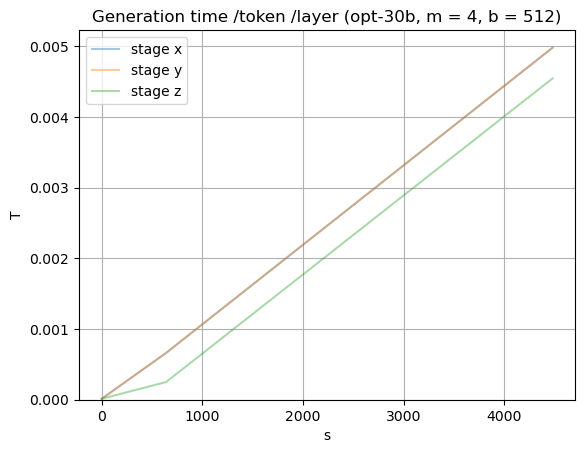

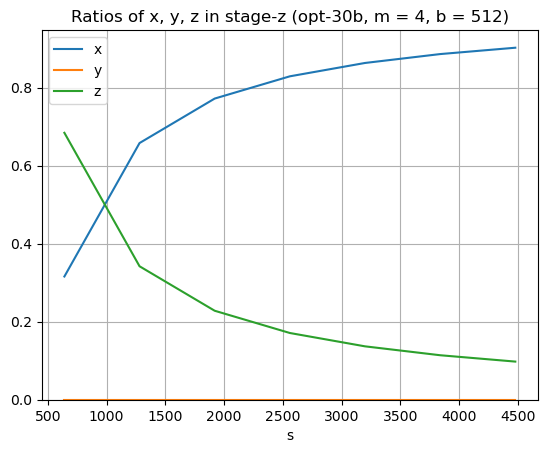

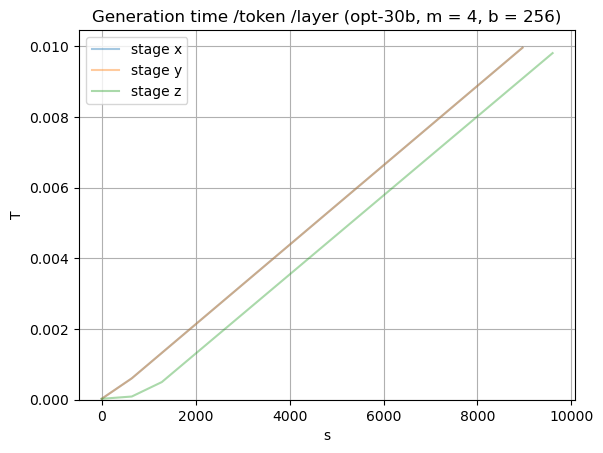

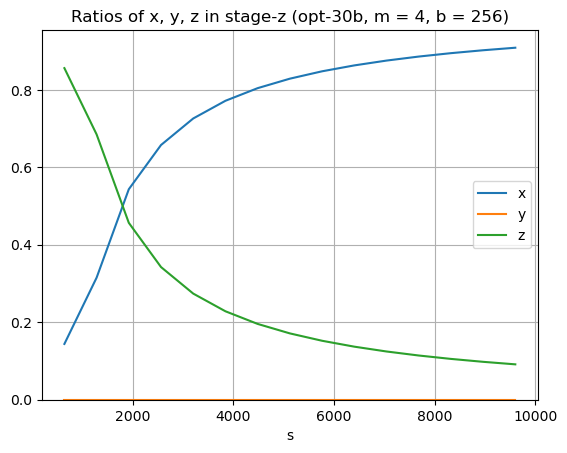

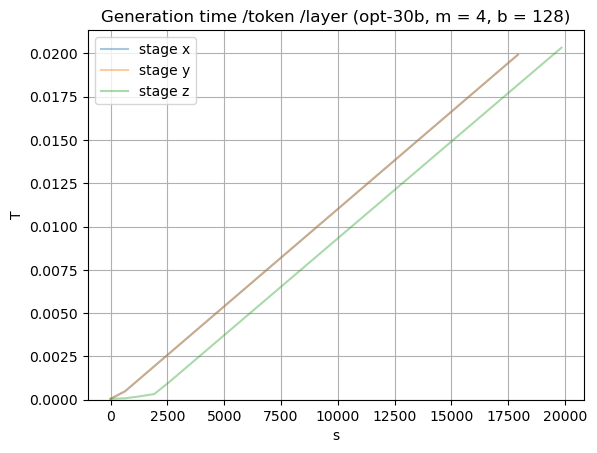

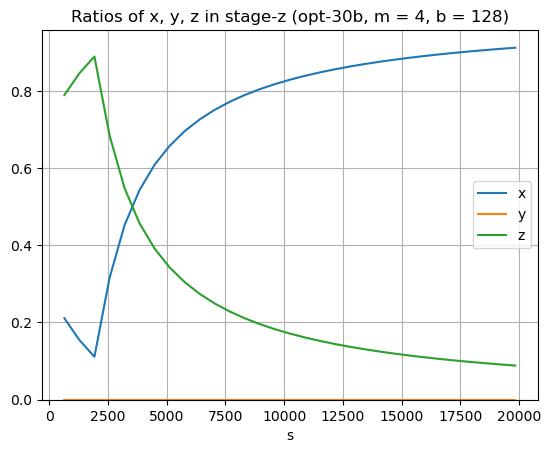

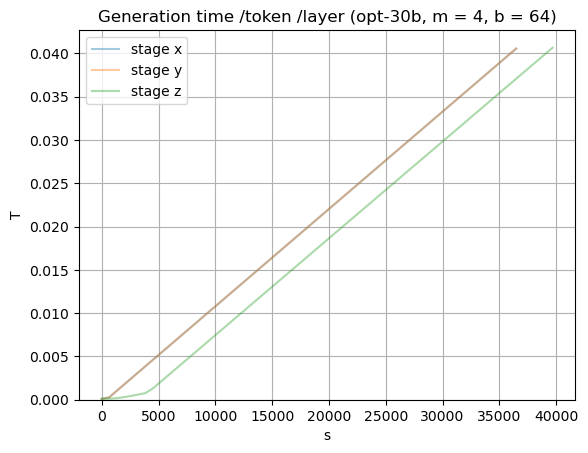

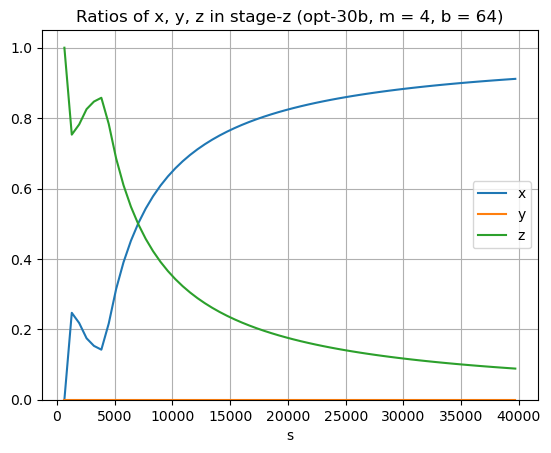

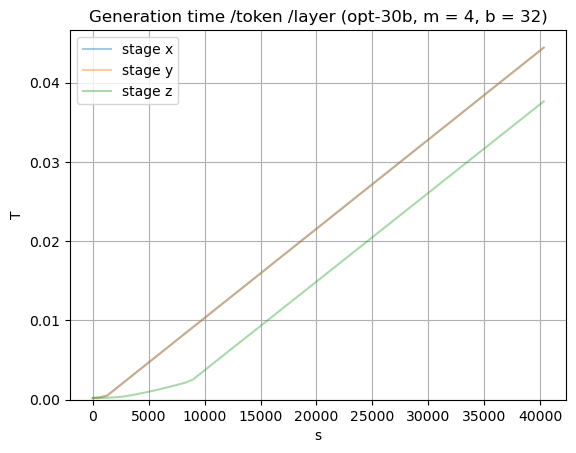

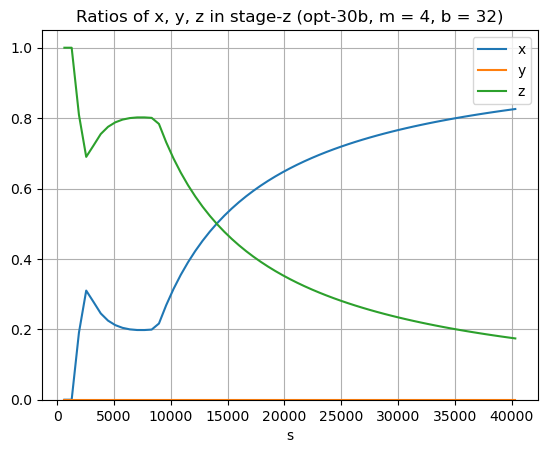

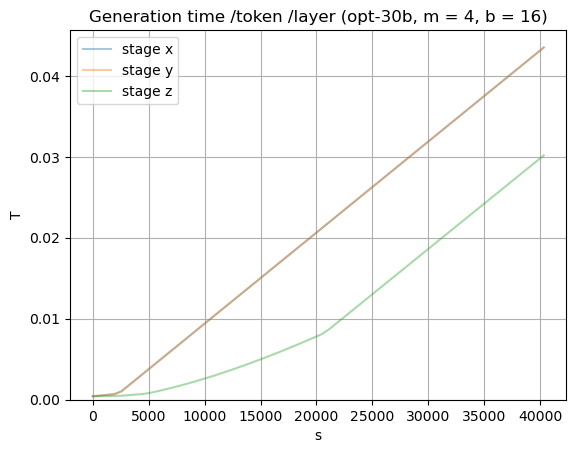

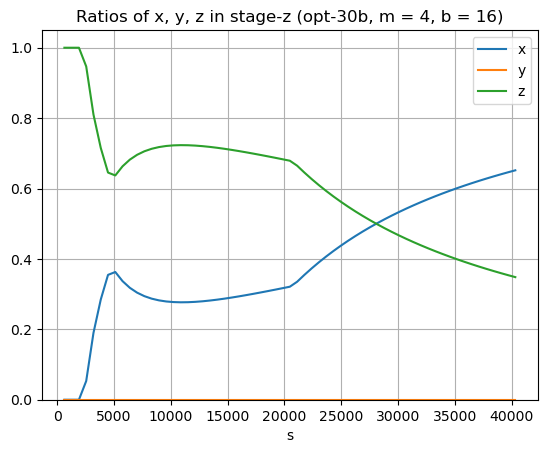

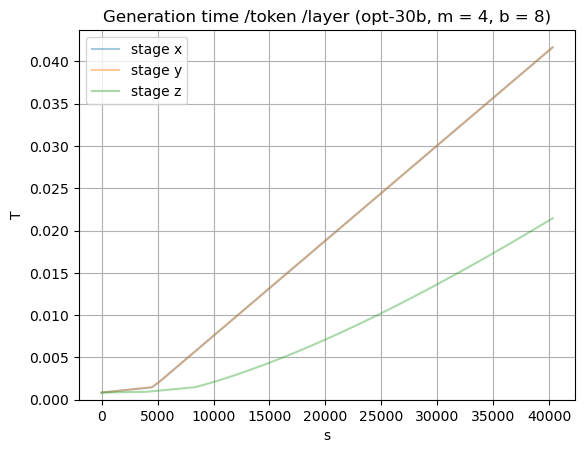

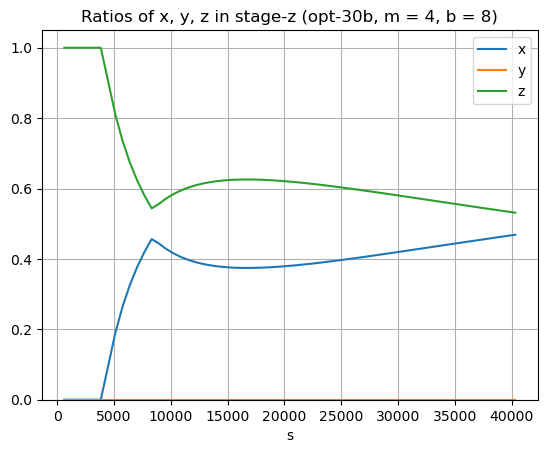

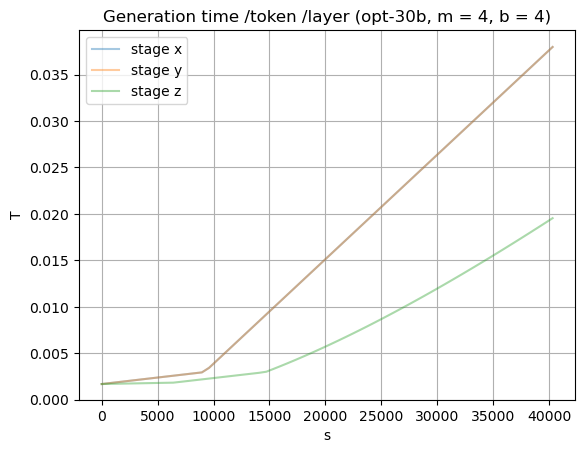

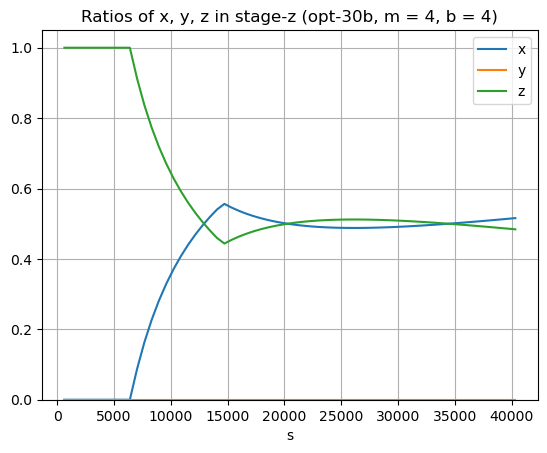

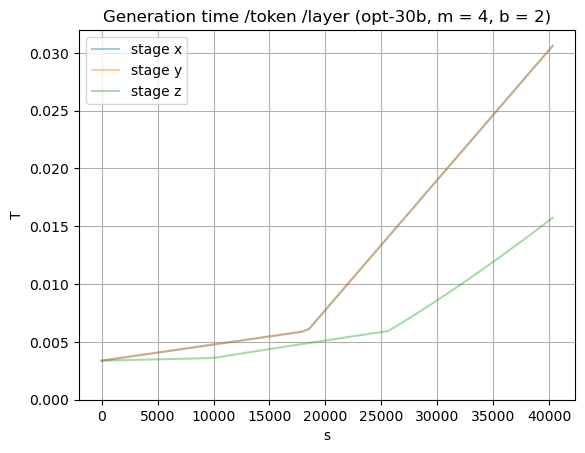

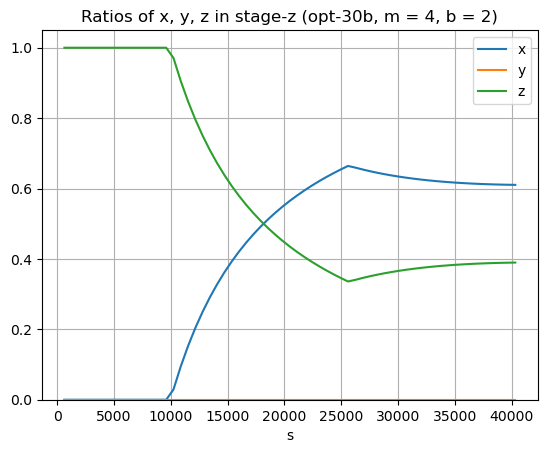

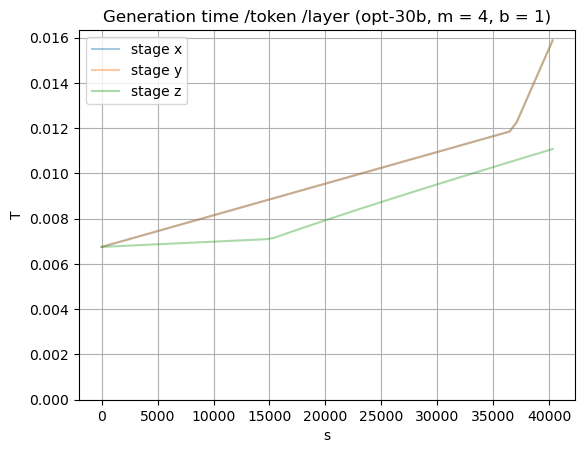

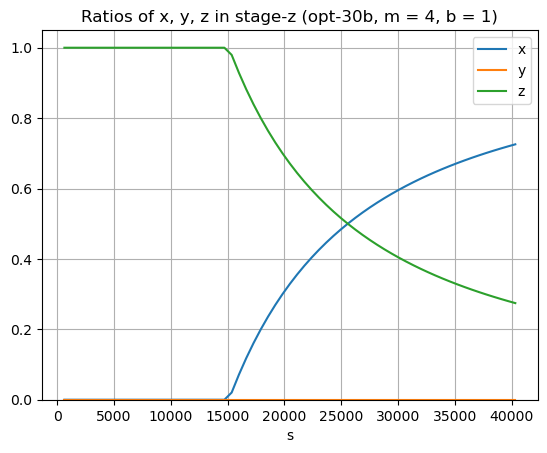

In [46]:
plot(mode=Mode.M4Bb)

In [47]:
# plot(mode=Mode.M1Bb, model_name='opt-125m')